# Tutorial: Qiskit-Braket provider overview

### Qiskit to Braket mapping

![qiskit-to-braket-diagram](./data/qiskit-braket-mapping.png)

In [1]:
# pip install qiskit_braket_provider

---------------

Import all required classes and functions for this overview

In [1]:
from qiskit.algorithms import VQE
from qiskit.opflow import (
    I,
    X,
    Z,
)
from qiskit import transpile, QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from braket.aws import AwsQuantumJob

from qiskit_braket_provider import AWSBraketProvider, BraketLocalBackend

C:\Users\ashmi\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ashmi\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ashmi\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Access Braket devices from Qiskit 

`AWSBraketProvider` class gives you a method `backends` to access backends that are available through Braket SDK.

Let's get available devices to use by Qiskit

In [3]:
provider = AWSBraketProvider()
backends = provider.backends()
backends

[BraketBackend[Aspen-10],
 BraketBackend[Aspen-11],
 BraketBackend[Aspen-8],
 BraketBackend[Aspen-9],
 BraketBackend[Aspen-M-1],
 BraketBackend[Aspen-M-2],
 BraketBackend[IonQ Device],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

For prototyping it is usually a good practice to use simulators 
to set up workflow of your program and then change it to real device.
We can access local simulator by creating instance of class `BraketLocalBackend`

In [4]:
local_simulator = BraketLocalBackend()
local_simulator

BraketBackend[sv_simulator]

We also get get cloud state vector simulator by using method `get_backend` for provider.

In [5]:
aws_statevector_simulator = provider.get_backend("SV1")
aws_statevector_simulator

BraketBackend[SV1]

Of course we can query for specific real devices 

In [6]:
ionq_device = provider.get_backend("IonQ Device")
rigetti_device = provider.get_backend("Aspen-M-1")

ionq_device, rigetti_device

(BraketBackend[IonQ Device], BraketBackend[Aspen-M-1])

And if you want to explore what is available by specific contraints, 
you can specify query arguments to `backends` method of provider.
Arguments are fully compatible with Braket's `get_device` method. See full doc [here](https://amazon-braket-sdk-python.readthedocs.io/en/stable/_apidoc/braket.aws.aws_device.html#braket.aws.aws_device.AwsDevice.get_devices).

In [7]:
online_simulators_backends = provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])
online_simulators_backends

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]

### Running circuits on AWS devices



Let's create circuit first. We will start with "Hello World" example :)

In [8]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

Run job agains selected device

In [9]:
job = aws_statevector_simulator.run(qc, shots=10)
job

Plot histogram

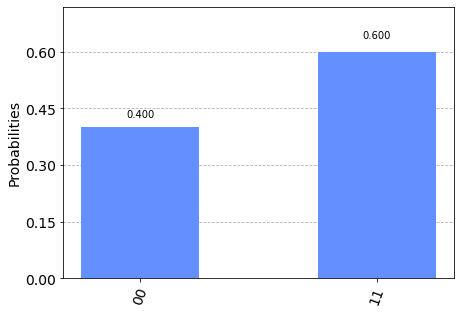

In [10]:
plot_histogram(job.result().get_counts())

Retrieve the measured state of each single shot.

In [11]:
job.result().get_memory()

['00', '11', '11', '11', '00', '00', '11', '11', '11', '00']

Now it's time to run more complex circuits on devices we got in previous paragraphs.

We will start with generating random circuit and printing it out.

In [10]:
circuit = random_circuit(6, 20, seed=42)
circuit.draw(fold=-1)

┌───┐        ┌───┐                                          ┌──────────────────────────┐┌──────────────┐                                                                                                   ┌─────────────┐    ┌───┐                                                                                           ┌───────────────────┐┌────────────┐┌────────────┐                                                                     
q_0: ───┤ T ├────────┤ S ├───────────────────X───■───────────■──────┤ U3(4.2086,2.7467,5.2319) ├┤ Rx(0.046259) ├──────────────────────────────────■────────────────────────────────────────X───────────■───────────┤ Ry(0.95701) ├────┤ Y ├───────■─────────■─────────────────────────────────────────■───────────────────────■───────┤ U2(3.0304,4.9181) ├┤ Rz(1.6775) ├┤ U1(4.2238) ├────────────────────────────────────────────────────────■────────────
     ┌──┴───┴───┐    └───┘                   │ ┌─┴─┐         │      └──────────────────────────┘└──────────────┘┌─────┐┌────────────────────────┐ │           ┌──────────────────────────┐ │           │           └┬────────────┤    └───┘       │         │             ┌───┐                       │                       │       └───────────────────┘└─────┬──────┘└────────────┘┌─────┐                             ┌────────────┐      │            
q_1: ┤ U1(6.13) ├────────────────────X───────X─┤ X ├─────────┼───────────────────X─────────────────────X────────┤ Tdg ├┤ U3(2.96,3.5515,4.8066) ├─┼───────────┤ U3(0.36633,1.768,1.8447) ├─┼───────────■────────────┤ Rz(2.8033) ├─■──────────────┼────■────┼─────────────┤ T ├───────────────────■───┼───────────────────────■─────────────────■────────────────┼─────────────■───────┤ Sdg ├─────────────────────────────┤ Rz(5.2137) ├──────┼────────────
     └──────────┘┌────────────┐      │       │ └─┬─┘         │                   │                     │        ├─────┤└───────────┬────────────┘ │U1(3.4782) └──────────┬───┬───────────┘ │         ┌─┴─┐          └─────┬──────┘ │ZZ(0.74145)   │    │    │  ┌──────────┴───┴───────────┐┌───┐  │   │                       │                 │                │           ┌─┴─┐     └┬───┬┘                             └─────┬──────┘      │            
q_2: ─────X──────┤ Ry(4.0455) ├──────┼───■───┼───┼───■───────┼───────────────────X─────────────────────X────────┤ Sdg ├────────────┼──────────────■──────────────────────┤ Z ├─────────────┼─────────┤ X ├────────────────■────────■──────────────┼────■────┼──┤ U3(1.9224,3.6393,1.1107) ├┤ Y ├──┼───┼─────────────■─────────┼─────────────────■────────────────┼───────────┤ X ├──────┤ X ├────────────────────────────────────┼─────────────┼─────────■──
          │      └───┬───┬────┘      │   │   │   │   │       │                   │                   ┌───┐      ├─────┤            │                 ┌───┐               └───┘             │         ├───┤              ┌───┐                     │  ┌─┴─┐  │  └──────────────────────────┘└─┬─┘  │   │           ┌─┴─┐       │                                  │           └─┬─┘      └───┘ ┌───────────────────────────┐      │             │       ┌─┴─┐
q_3: ─────┼──────────┤ T ├───────■───┼───┼───■───┼───X───────┼───────────────────■───────────────────┤ X ├──────┤ Tdg ├────────────■─────────────────┤ Z ├─────────────────────────────────┼─────────┤ H ├──────────────┤ X ├───────────■─────────┼──┤ X ├──■────────────────────────────────■────┼───┼───────────┤ Y ├───────┼─────────────────■────────────────■─────────────┼──────────────┤ U3(4.8296,0.67696,5.7555) ├──────┼─────────────┼───────┤ Y ├
          │          └───┘       │   │ ┌─┴─┐     │   │     ┌─┴─┐               ┌───┐                 └───┘      ├─────┤                              └───┘                                 │         └─┬─┘              └─┬─┘           │       ┌─┴─┐└───┘┌─┴─┐                                 ┌─┴─┐ │           └───┘     ┌─┴─┐         ┌─────┴──────┐       ┌───┐           │        ┌───┐ └─────────────┬─────────────┘      │       ┌─────┴──────┐└───┘
q_4

Here is a good point to talk about circuit transpilation. 

Transpilation is the process of rewriting a given input circuit 
to match the topology of a specific quantum device, and/or to optimize the 
circuit for execution on present day noisy quantum systems.

Let's transpile our generated circuit agains selected device.

In [11]:
transpiled_circuit = transpile(circuit, backend=ionq_device, seed_transpiler=42)
transpiled_circuit.draw(idle_wires=False, fold=-1)

global phase: 3.2614
           ┌──────────┐                                                                                                       ┌───┐   ┌───┐     ┌─────┐  ┌───┐ ┌───┐ ┌───┐┌─────┐┌───┐ ┌───┐  ┌───┐                                                        ┌───┐            ┌───┐ ┌─────┐┌───┐                 ┌────────────┐┌────────────┐┌────────────┐                                                                                                                                                                                     ┌───┐                                                                   ┌───┐      ┌───┐┌─────┐┌───┐     ┌───┐                                                                                 ┌───┐          ┌─────────────┐                                                                                                                                                                                            ┌───┐                                                                     ┌───┐      ┌───┐┌─────┐┌───┐┌──────────────────────┐                                                                                                        ┌───┐                         ┌─────────────┐       ┌─────────┐       ┌─────────────┐               ┌───┐┌────────────────────────┐┌───┐┌──────────────────────┐                                                                                                                                                                                                                                
q_0: ──────┤ Rz(3π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────■───────┤ H ├───┤ X ├─────┤ Tdg ├──┤ X ├─┤ T ├─┤ X ├┤ Tdg ├┤ X ├─┤ T ├──┤ H ├────────■─────────■────────────────────────────────■────┤ T ├────────────┤ X ├─┤ Tdg ├┤ X ├──────────────■──┤ Rz(2.1395) ├┤ Ry(2.0919) ├┤ Rz(1.3684) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────────■─────────────────────┤ X ├───────────────────────────────■───────────────────────────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├─────┤ X ├────────────■──────────────────────────────────────────────────────────■─────■───┤ T ├───■──────┤ Ry(-2.1846) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────■───────────────■───┤ T ├────────■──────────────────■─────────────────────────────────────■───┤ T ├──────┤ X ├┤ Tdg ├┤ X ├┤ Rz(1.30629747996744) ├───────────────────■──────────────────────────────────■─────────■──────────────────────────────■────■───┤ T ├────────────■────────────┤ Rz(-1.3651) ├───────┤ Ry(π/2) ├───────┤ Rz(-2.4141) ├───────────────┤ X ├┤ Rz(-0.838728781856755) ├┤ X ├┤ Rz(4.22380907548478) ├──────────────────────────■─────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     ┌─────┴──────────┴─────┐                                                                                       ┌─┴─┐     └───┘   └─┬─┘     └─────┘  └─┬─┘ └───┘ └─┬─┘└┬───┬┘└─┬─┘ ├───┤ ┌┴───┴┐┌───┐┌─┴─┐┌───┐┌─┴─┐┌─────┐          ┌───┐┌───┐ ┌─┴─┐ ┌┴───┴┐┌───┐┌───┐ └─┬─┘ └┬───┬┘└─┬─┘              │  └────────────┘└────────────┘└───┬───┬────┘                                                 ┌───┐           ┌───┐┌─────┐┌───┐     ┌───┐               ┌──────────────┐  │  ┌───┐     ┌────────────┐       │  ┌───────────┐ ┌───┐└─┬─┘┌──────────────┐┌───────────┐  │  ┌─────────────┐              │   └───┘      └─┬─┘└─────┘└─┬─┘     └─┬─┘            │                                                 ┌───┐    │   ┌─┴─┐┌┴───┴┐┌─┴─┐┌───┴─────────────┴────┐┌───┐┌───────────────────────┐ ┌───┐                                                                                           

We can run our circuit and get job object back, which will store information about execution: job id, status of job and results when it will be available

In [ ]:
ionq_job = ionq_device.run(transpiled_circuit, shots=10)
ionq_job.job_id()

If we do not want to wait for a job completion and return to it later, we can use `retrieve_job` method on device to get job object

In [28]:
retrieved_job = ionq_device.retrieve_job(job_id="<TASK_ARN>")
retrieved_job

Check status

In [29]:
retrieved_job.status()

<JobStatus.DONE: 'job has successfully run'>

And plot histogram of results

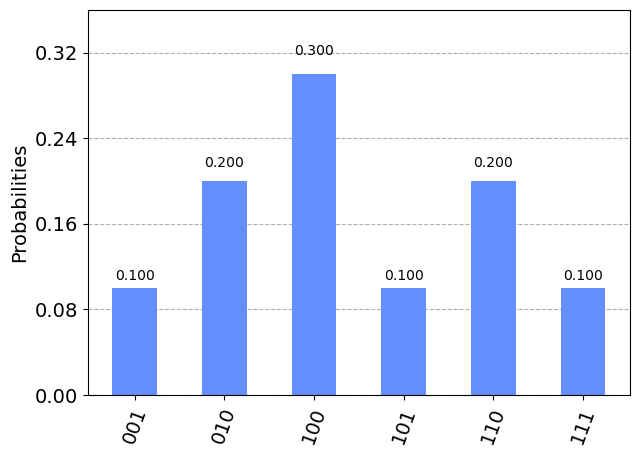

In [30]:
plot_histogram(retrieved_job.result().get_counts())

### Running algorithms

Let's review an example of running algorithms using Qiskit on Braket devices.

Qiskit provides a number of Algorithms and they are grouped by category according to the task they can perform. For instance Minimum Eigensolvers to find the smallest eigen value of an operator, for example ground state energy of a chemistry Hamiltonian or a solution to an optimization problem when expressed as an Ising Hamiltonian.

Algorithms are configurable and often part of the configuration will be in the form of smaller building blocks, of which different instances of the building block type can be given. For instance with `VQE`, the Variational Quantum Eigensolver, it takes a trial wavefunction, in the form of a `QuantumCircuit` and a classical optimizer among other things.

Let’s take a look at an example to construct a VQE instance. Here `TwoLocal` is the variational form (trial wavefunction), a parameterized circuit which can be varied, and SLSQP a classical optimizer. Then we pass hamiltonian to `compute_minimum_eigenvalue` method of `VQE` to get result.

Full example and explanation of algorithm detail you can find [here](https://qiskit.org/documentation/tutorials/algorithms/01_algorithms_introduction.html#An-Introduction-to-Algorithms-in-Qiskit).



In [19]:
H2_op = (
    (-1.052373245772859 * I ^ I)
    + (0.39793742484318045 * I ^ Z)
    + (-0.39793742484318045 * Z ^ I)
    + (-0.01128010425623538 * Z ^ Z)
    + (0.18093119978423156 * X ^ X)
)

qi = QuantumInstance(local_simulator, seed_transpiler=42, seed_simulator=42)
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
slsqp = SLSQP(maxiter=1)

vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=qi)

result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 9,
    'eigenstate': {   '00': 0.04419417382415922,
                      '01': 0.94631274560792,
                      '10': 0.19515618744994995,
                      '11': 0.2538762001448738},
    'eigenvalue': (-1.6891153397630962+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -1.5057852302979455,
                              ParameterVectorElement(θ[1]): 0.17806892747075853,
                              ParameterVectorElement(θ[2]): -2.9377191205349478,
                              ParameterVectorElement(θ[3]): -6.1111063638168925,
                              ParameterVectorElement(θ[4]): 0.5757868603404876,
                              ParameterVectorElement(θ[5]): 0.6859617452099496,
                              ParameterVectorElement(θ[6]): -5.657884129072659,
                              ParameterVectorElement(θ[7]): 0.7981284053630464},
    'optimal_point': array([-1.50578523,  0.178068

### Running Hybrid Jobs

Amazon Braket Hybrid Jobs enables you to easily run hybrid quantum-classical algorithms, such as the Variational Quantum Eigensolver (VQE) and the Quantum Approximate Optimization Algorithm (QAOA), that combine classical compute resources with quantum computing devices to optimize the performance of today’s quantum systems. 

In order to run Hybrid Job we need to acomplish couple of step:

1. Prepare script

In [4]:
! cat ./data/2_hybrid_jobs/job_script.py

"""Example of Hybrid Job payload with VQE."""
from braket.jobs import save_job_result
from qiskit.opflow import (
    I,
    X,
    Z,
)
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance

from qiskit_braket_provider import AWSBraketProvider


def main():
    backend = AWSBraketProvider().get_backend("SV1")

    h2_op = (
        (-1.052373245772859 * I ^ I)
        + (0.39793742484318045 * I ^ Z)
        + (-0.39793742484318045 * Z ^ I)
        + (-0.01128010425623538 * Z ^ Z)
        + (0.18093119978423156 * X ^ X)
    )

    quantum_instance = QuantumInstance(
        backend, seed_transpiler=42, seed_simulator=42, shots=10
    )
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    slsqp = SLSQP(maxiter=1)

    vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=quantum_instance)

    vqe_result = vqe.compute_minimum_eigenvalue(h2_op)

    save_job_

2. Prepare image

In [5]:
! cat ./data/2_hybrid_jobs/Dockerfile

FROM 292282985366.dkr.ecr.us-west-2.amazonaws.com/amazon-braket-base-jobs:1.0-cpu-py37-ubuntu18.04

RUN python3 -m pip install --upgrade pip

RUN python3 -m pip install --no-cache --upgrade git+https://github.com/qiskit-community/qiskit-braket-provider


3. Run Hybrid Job

In [ ]:
image_uri = "<ACCOUNT_ID>.dkr.ecr.<AWS_REGION>.amazonaws.com/amazon-braket-qiskit-provider:latest"

job = AwsQuantumJob.create(
    device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
    source_module="data/2_hybrid_jobs/job_script.py",
    entry_point="job_script:main",
    wait_until_complete=False,
    job_name="qiskit-braket-vqe",
    image_uri=image_uri,
)

In [ ]:
# print(job.result())
AwsQuantumJob("<JOB_ARN>").result()